### Two set of metrics are demonstrated for all data
1. 80-20 validation, with validation error demonstrated as peformance metric. The 80-20 validation is used for selecting the 2D descriptors
2. five-fold cross validation, with average CV error demonstrated as performance metric

Note: The Ehull value shows in the data are actually Ehull (1000K), this is calculated by Ehull(1000K) = Ehull(DFT) - S_ideal*1000K. The reason of doing that is because we use Ehull(1000K) to seperate GS/LS with US NASICONs

In [1]:
%matplotlib inline
import pandas as pd
from pandas import DataFrame
import os
from sklearn.metrics import accuracy_score, f1_score, recall_score
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import LinearSVC,SVC
from copy import deepcopy
import json
from matplotlib import pyplot as plt

from pymatgen.core.composition import Composition


prefix = os.getcwd()

In [2]:
train_2D_df = pd.read_csv('train_2D.csv')
test_2D_df = pd.read_csv('test_2D.csv')

In [3]:
train_2D_df.head()

,CompName,Ehull,(cbrt(NNaLst)+(AnionChgStdLst)^2),((EWaldSumLst)^2*(XWithNaLst*RDiffStdLst))
0,MgZr(SO4)3,-60.260567,0.0,0.000000
1,MgTi(SO4)3,-27.986572,0.0,125.960243
2,MgSn(SO4)3,-30.640966,0.0,46.109451
3,Mg4Nb2(SO4)9,-42.783127,0.0,79.651306
4,ZrZn(SO4)3,-40.419098,0.0,24.253452


In [4]:
Ehull_train = train_2D_df['Ehull'].to_numpy()
Y_total = np.zeros_like(Ehull_train)
Y_total[np.where(Ehull_train<=0)] = 0
Y_total[np.where(Ehull_train>0)] = 1
X_total = train_2D_df[['(cbrt(NNaLst)+(AnionChgStdLst)^2)','((EWaldSumLst)^2*(XWithNaLst*RDiffStdLst))']].to_numpy()

Ehull_test = test_2D_df['Ehull'].to_numpy()
Y_valid = np.zeros_like(Ehull_test)
Y_valid[np.where(Ehull_test<=0)] = 0
Y_valid[np.where(Ehull_test>0)] = 1
X_valid = test_2D_df[['(cbrt(NNaLst)+(AnionChgStdLst)^2)','((EWaldSumLst)^2*(XWithNaLst*RDiffStdLst))']].to_numpy()
print(np.unique(Y_total),np.unique(Y_valid))

[0. 1.] [0. 1.]


## Performance metric on 20% of the validation data (out of the training sample)

In [5]:
# The SVC validation error from 80-20 splitting

clf = SVC(kernel='linear',class_weight='balanced',probability=True)
clf.fit(X_total,Y_total)
Y_valid_predict = clf.predict(X_valid)
test_score = accuracy_score(Y_valid,Y_valid_predict)
test_recall = recall_score(Y_valid,Y_valid_predict,average='macro')
test_F1 = f1_score(Y_valid,Y_valid_predict,average='macro')
print(f'Accuracy = {test_score}, recall = {test_recall}, F1 score = {test_F1}')

Accuracy = 0.8236808236808236, recall = 0.8129213212634823, F1 score = 0.7426486764837428


## Performance metric on five fold cross validation

In [6]:
skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=0)

In [7]:
X_all_data = np.concatenate((X_total,X_valid))
Y_all_data = np.concatenate((Y_total,Y_valid))
ehull_all_data = np.concatenate((Ehull_train,Ehull_test))

In [8]:
print(Y_all_data.shape,X_all_data.shape)

(3881,) (3881, 2)


In [9]:
# The real train set = train set from skf + the validation data set
accuracy_lst, recall_lst, F1_lst = [], [], []

best_test_score = 1e10

for train_index, test_index in skf.split(X_all_data,Y_all_data):
    X_train = X_all_data[train_index]
    X_test = X_all_data[test_index]
    Y_train = Y_all_data[train_index]
    Y_test = Y_all_data[test_index]
    
    clf = SVC(kernel='linear',class_weight='balanced',probability=True)

    clf.fit(X_train, Y_train)
    Y_cv_predict = clf.predict(X_test)
    
    test_score = accuracy_score(Y_test,Y_cv_predict)
    test_recall = recall_score(Y_test,Y_cv_predict,average='macro')
    test_F1 = f1_score(Y_test,Y_cv_predict,average='macro')
    
    accuracy_lst.append(test_score)
    recall_lst.append(test_recall)
    F1_lst.append(test_F1)
    
    if test_score < best_test_score:
        best_test_score = test_score
        best_clf = deepcopy(clf)
        best_train_index, best_test_index = deepcopy(train_index), deepcopy(test_index)
        best_X_train, best_Y_train = deepcopy(X_train), deepcopy(Y_train)
        best_X_test, best_Y_test = deepcopy(X_test), deepcopy(Y_test)
    
    print(f'Accuracy = {test_score}, recall = {test_recall}, F1 score = {test_F1}')
    
print(f'Average accuracy = {np.average(accuracy_lst)}, recall = {np.average(recall_lst)}, F1 score = {np.average(F1_lst)}')

Accuracy = 0.8301158301158301, recall = 0.8484783232845248, F1 score = 0.7604585116122643
Accuracy = 0.8067010309278351, recall = 0.8152970679012346, F1 score = 0.7297924694739775
Accuracy = 0.8131443298969072, recall = 0.8128858024691358, F1 score = 0.7341505078594768
Accuracy = 0.845360824742268, recall = 0.8760609567901234, F1 score = 0.7812934500770359
Accuracy = 0.8092783505154639, recall = 0.810570987654321, F1 score = 0.7302619217616775
Average accuracy = 0.820920073239661, recall = 0.8326586276198679, F1 score = 0.7471913721568864


## Plot all the data with the decision boundary that has highest validation accuracy/F1

In [10]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

train_df = train_df.set_index('CompName')
test_df = test_df.set_index('CompName')

e_Ewald_ref = train_df.loc['Na3Zr2Si2PO12']['EWaldSumLst']
r_ref = 1.02 # The shannon radius of Na+

norm_factor = 1/(e_Ewald_ref**2*r_ref)
print(f'norm_factor is {norm_factor}')

norm_factor is 0.0005422912481778321


(3105, 2) (3105,)


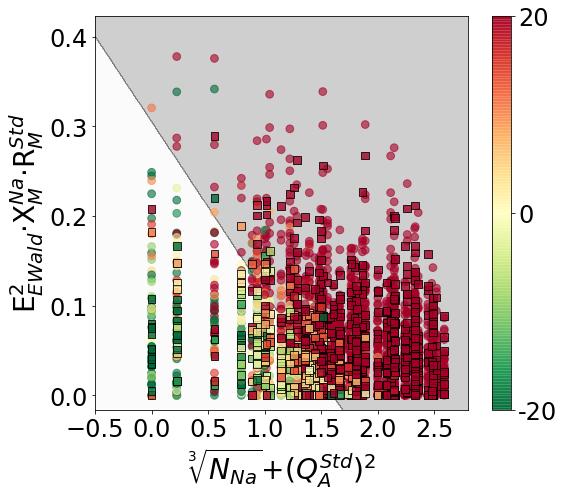

In [11]:
plt.figure(figsize=(8,7))
x_min, x_max = best_X_train[:,0].min()-0.5, best_X_train[:, 0].max()+0.5
y_min, y_max = best_X_train[:,1].min()-50, best_X_train[:, 1].max()+100

plot_stepx = (x_max-x_min)/500;
plot_stepy = (y_max-y_min)/500;
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_stepx),
                     np.arange(y_min, y_max, plot_stepy))
Z = best_clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

cs = plt.contourf(xx, yy, Z, cmap=plt.cm.binary,alpha=0.2)

ehull_train_arry = ehull_all_data[best_train_index]
ehull_test_arry = ehull_all_data[best_test_index]
print(best_X_train.shape,ehull_train_arry.shape)

plt.scatter(best_X_train[:,0],best_X_train[:,1],marker='o',s=[60 for i in range(ehull_train_arry.shape[0])],
            c=ehull_train_arry,cmap='RdYlGn_r',vmin=-20,vmax=20,alpha=0.6)
plt.scatter(best_X_test[:,0],best_X_test[:,1],marker='s',s=[60 for i in range(ehull_test_arry.shape[0])],
            c=ehull_test_arry,edgecolors=['k' for i in range(ehull_train_arry.shape[0])],
            cmap='RdYlGn_r',vmin=-20,vmax=20,alpha=0.8)


CB=plt.colorbar()
CB.ax.tick_params(labelsize=24)
CB.set_ticks([-20,0,20]); CB.set_ticklabels(['-20','0','20'])
_ = plt.yticks([0.00/norm_factor,0.10/norm_factor,0.20/norm_factor,0.30/norm_factor,0.40/norm_factor],
           [0.0,0.1,0.2,0.3,0.4])
_ = plt.xticks(fontsize=24); plt.yticks(fontsize=24)
plt.xlabel('$\sqrt[3]{N_{Na}}$+($Q_{A}^{Std}$)$^2$',fontsize=28)
plt.ylabel(r'E$_{EWald}^2$$\cdot$X$_{M}^{Na}$$\cdot$R$_{M}^{Std}$',fontsize=28)
plt.xlim((-0.5,2.8)) 
plt.ylim((-30,780))
plt.tight_layout()
plt.savefig('Fig.')

## plot experimentally reported NASICONs

In [12]:
import json

with open('exp_comps.json','r') as fid:
    exp_comp_dict = json.load(fid)
    
reported_exp_comps = exp_comp_dict['reported_exp_comps']
new_exp_comps = exp_comp_dict['new_exp_comps']

all_comp_names = train_2D_df['CompName'].to_list() + test_2D_df['CompName'].tolist()

reported_exp_inds = [all_comp_names.index(exp_comp) for exp_comp in reported_exp_comps]
new_exp_inds = [all_comp_names.index(exp_comp) for exp_comp in new_exp_comps]

print(len(reported_exp_comps), len(new_exp_comps))
print(len(reported_exp_inds), len(new_exp_inds))

27 5
27 5


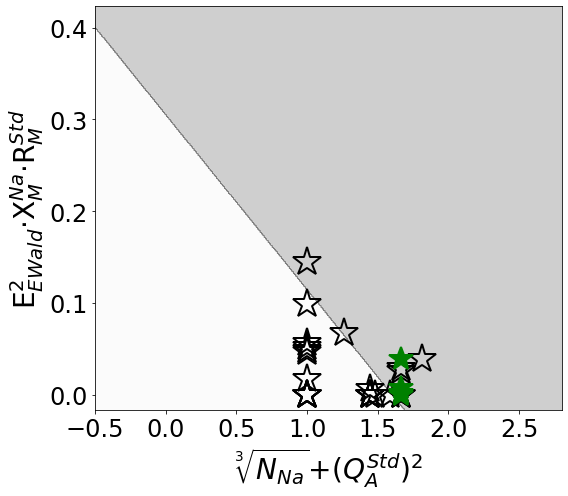

In [13]:
plt.figure(figsize=(8,7))
x_min, x_max = best_X_train[:,0].min()-0.5, best_X_train[:, 0].max()+0.5
y_min, y_max = best_X_train[:,1].min()-50, best_X_train[:, 1].max()+100

plot_stepx = (x_max-x_min)/500;
plot_stepy = (y_max-y_min)/500;
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_stepx),
                     np.arange(y_min, y_max, plot_stepy))
Z = best_clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

cs = plt.contourf(xx, yy, Z, cmap=plt.cm.binary,alpha=0.2)

ehull_train_arry = ehull_all_data[best_train_index]
ehull_test_arry = ehull_all_data[best_test_index]

plt.plot(X_all_data[reported_exp_inds,0],X_all_data[reported_exp_inds,1],'*',fillstyle='none',
         color='k',markersize=30,label='Reported NASICON',alpha=1.0,markeredgewidth=2)
plt.plot(X_all_data[new_exp_inds,0],X_all_data[new_exp_inds,1],'*',fillstyle='full',color='g',markersize=25,\
         label='This Work',alpha=1.0,markeredgewidth=2)
_ = plt.yticks([0.00/norm_factor,0.10/norm_factor,0.20/norm_factor,0.30/norm_factor,0.40/norm_factor],
           [0.0,0.1,0.2,0.3,0.4])
_ = plt.xticks(fontsize=24); plt.yticks(fontsize=24)
plt.xlabel('$\sqrt[3]{N_{Na}}$+($Q_{A}^{Std}$)$^2$',fontsize=28)
plt.ylabel(r'E$_{EWald}^2$$\cdot$X$_{M}^{Na}$$\cdot$R$_{M}^{Std}$',fontsize=28)
plt.xlim((-0.5,2.8)) 
plt.ylim((-30,780))
plt.tight_layout()

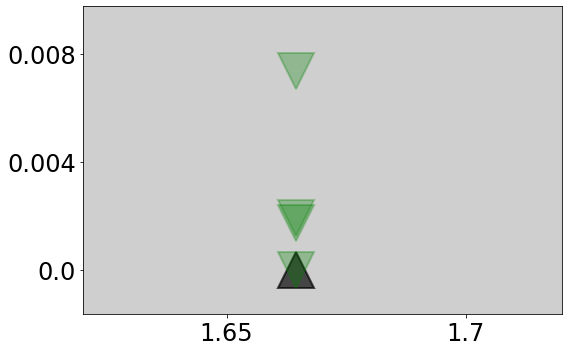

In [14]:
# Zoom in the five newly synthesized compounds

plt.figure(figsize=(8,5))

x_min, x_max = best_X_train[:,0].min()-0.5, best_X_train[:, 0].max()+0.5
y_min, y_max = best_X_train[:,1].min()-50, best_X_train[:, 1].max()+100

plot_stepx = (x_max-x_min)/500;
plot_stepy = (y_max-y_min)/500;
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_stepx),
                     np.arange(y_min, y_max, plot_stepy))
Z = best_clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

cs = plt.contourf(xx, yy, Z, cmap=plt.cm.binary,alpha=0.2)

ehull_train_arry = ehull_all_data[best_train_index]
ehull_test_arry = ehull_all_data[best_test_index]

plt.plot(X_all_data[reported_exp_inds,0],X_all_data[reported_exp_inds,1],'^',fillstyle='full',color='k',markersize=36,label='Reported NASICON',\
         alpha=0.3,markeredgewidth=2)
plt.plot(X_all_data[new_exp_inds,0],X_all_data[new_exp_inds,1],'v',fillstyle='full',color='g',markersize=36,\
         label='This Work',alpha=0.3,markeredgewidth=2,markeredgecolor='g')
plt.xlim((1.62,1.72)); plt.ylim((-3,18));
plt.xticks([1.65,1.7],[1.65,1.7],fontsize=24);
plt.yticks([0.00/norm_factor,0.004/norm_factor,0.008/norm_factor],
           [0.0,0.004,0.008],fontsize=24)
plt.tight_layout()

## plot Na rich and Na poor NASICONs

In [15]:
def obtain_NNa(comp_lst):
    NNa_lst = []
    for reduced_formula in comp_lst:
        NNa = Composition(reduced_formula)['Na']/Composition(reduced_formula)['O']*12.0
        NNa_lst.append(NNa)
        
    return np.array(NNa_lst)

ehull_train_arry = ehull_all_data[best_train_index]
ehull_test_arry = ehull_all_data[best_test_index]
train_comp_names = [all_comp_names[i] for i in best_train_index]
test_comp_names = [all_comp_names[i] for i in best_test_index]

NNa_train_arry = obtain_NNa(train_comp_names)
NNa_test_arry = obtain_NNa(test_comp_names)

NaPoor_LSGS_train_ind = np.where((NNa_train_arry<=1.0) & (ehull_train_arry<=0))[0]
NaRich_LSGS_train_ind = np.where((NNa_train_arry>=3.0) & (ehull_train_arry<=0))[0]
NaPoor_LSGS_test_ind = np.where((NNa_test_arry<=1.0) & (ehull_test_arry<=0))[0]
NaRich_LSGS_test_ind = np.where((NNa_test_arry>=3.0) & (ehull_test_arry<=0))[0]

In [16]:
# The weighted ratio

ratio =  best_clf.class_weight_/best_clf.class_weight_.sum()
NaPoor_LSGS_train_proba = best_clf.predict_proba(best_X_train[NaPoor_LSGS_train_ind])*ratio
NaRich_LSGS_train_proba = best_clf.predict_proba(best_X_train[NaRich_LSGS_train_ind])*ratio
NaPoor_LSGS_test_proba = best_clf.predict_proba(best_X_test[NaPoor_LSGS_test_ind])*ratio
NaRich_LSGS_test_proba = best_clf.predict_proba(best_X_test[NaRich_LSGS_test_ind])*ratio

print(
    NaPoor_LSGS_train_proba.shape, NaRich_LSGS_train_proba.shape, \
    NaPoor_LSGS_test_proba.shape, NaRich_LSGS_test_proba.shape, \
    len(NaPoor_LSGS_train_ind), len(NaRich_LSGS_train_ind), \
    len(NaPoor_LSGS_test_ind), len(NaRich_LSGS_test_ind)
      )

(363, 2) (45, 2) (91, 2) (15, 2) 363 45 91 15


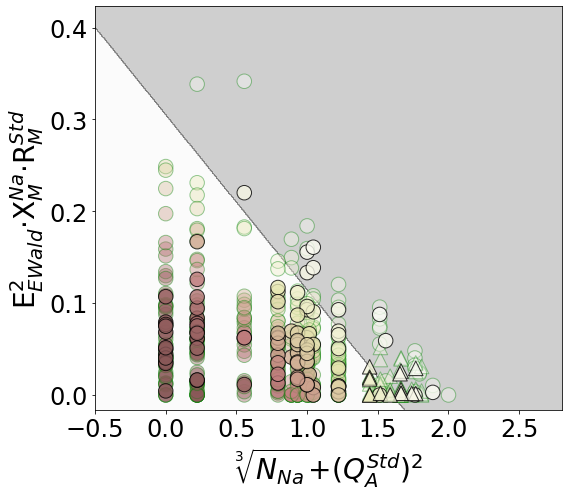

In [17]:
plt.figure(figsize=(8,7))
x_min, x_max = best_X_train[:,0].min()-0.5, best_X_train[:, 0].max()+0.5
y_min, y_max = best_X_train[:,1].min()-50, best_X_train[:, 1].max()+100

plot_stepx = (x_max-x_min)/500;
plot_stepy = (y_max-y_min)/500;
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_stepx),
                     np.arange(y_min, y_max, plot_stepy))
Z = best_clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

cs = plt.contourf(xx, yy, Z, cmap=plt.cm.binary,alpha=0.2)

ehull_train_arry = ehull_all_data[best_train_index]
ehull_test_arry = ehull_all_data[best_test_index]

plt.scatter(best_X_train[NaPoor_LSGS_train_ind,0],best_X_train[NaPoor_LSGS_train_ind,1],cmap='pink_r',marker='o',
         s=210,c=NaPoor_LSGS_train_proba[:,0],edgecolors=['g' for _ in range(len(NaPoor_LSGS_test_ind))],alpha=0.4,
            vmin=0.0,vmax=1.0)
plt.scatter(best_X_train[NaRich_LSGS_train_ind,0],best_X_train[NaRich_LSGS_train_ind,1],cmap='pink_r',marker='^',
         s=210,c=NaRich_LSGS_train_proba[:,0],edgecolors=['g' for _ in range(len(NaPoor_LSGS_test_ind))],alpha=0.4,
            vmin=0.0,vmax=1.0)
plt.scatter(best_X_test[NaPoor_LSGS_test_ind,0],best_X_test[NaPoor_LSGS_test_ind,1],cmap='pink_r',marker='o',
         s=210,c=NaPoor_LSGS_test_proba[:,0],edgecolors=['k' for _ in range(len(NaPoor_LSGS_test_ind))],alpha=0.8,
         vmin=0.0,vmax=1.0)
plt.scatter(best_X_test[NaRich_LSGS_test_ind,0],best_X_test[NaRich_LSGS_test_ind,1],cmap='pink_r',marker='^',
         s=210,c=NaRich_LSGS_test_proba[:,0],edgecolors=['k' for _ in range(len(NaRich_LSGS_test_ind))],alpha=0.8,
         vmin=0.0,vmax=1.0)

_ = plt.yticks([0.00/norm_factor,0.10/norm_factor,0.20/norm_factor,0.30/norm_factor,0.40/norm_factor],
           [0.0,0.1,0.2,0.3,0.4])
_ = plt.xticks(fontsize=24); plt.yticks(fontsize=24)
plt.xlabel('$\sqrt[3]{N_{Na}}$+($Q_{A}^{Std}$)$^2$',fontsize=28)
plt.ylabel(r'E$_{EWald}^2$$\cdot$X$_{M}^{Na}$$\cdot$R$_{M}^{Std}$',fontsize=28)
plt.xlim((-0.5,2.8)) 
plt.ylim((-30,780))
plt.tight_layout()

## plot Ca/Ge and Hf/Zr NASICONs

In [18]:
def obtain_NASICON_with_metal(comp_lst,ehull_arry,metals):
    NASICON_comp_lst, NASICON_comp_inds = [], []
    for i, reduced_formula in enumerate(comp_lst):
        NM = 0.0
        for metal in metals:
            NM += Composition(reduced_formula)[metal]/Composition(reduced_formula)['O']*12.0
        if NM > 0.0 and ehull_arry[i] <= 0:
            NASICON_comp_lst.append(reduced_formula)
            NASICON_comp_inds.append(i)
        
    return NASICON_comp_lst, NASICON_comp_inds


ehull_train_arry = ehull_all_data[best_train_index]
ehull_test_arry = ehull_all_data[best_test_index]
train_comp_names = [all_comp_names[i] for i in best_train_index]
test_comp_names = [all_comp_names[i] for i in best_test_index]

CaGe_train_comps, CaGe_train_inds = obtain_NASICON_with_metal(train_comp_names, ehull_train_arry, ['Ca','Ge'])
CaGe_test_comps, CaGe_test_inds = obtain_NASICON_with_metal(test_comp_names, ehull_test_arry, ['Ca','Ge'])
HfZr_train_comps, HfZr_train_inds = obtain_NASICON_with_metal(train_comp_names, ehull_train_arry, ['Hf','Zr'])
HfZr_test_comps, HfZr_test_inds = obtain_NASICON_with_metal(test_comp_names, ehull_test_arry, ['Hf','Zr'])

In [19]:
# The weighted ratio

ratio =  best_clf.class_weight_/best_clf.class_weight_.sum()
CaGe_LSGS_train_proba = best_clf.predict_proba(best_X_train[CaGe_train_inds])*ratio
CaGe_LSGS_test_proba = best_clf.predict_proba(best_X_test[CaGe_test_inds])*ratio
HfZr_LSGS_train_proba = best_clf.predict_proba(best_X_train[HfZr_train_inds])*ratio
HfZr_LSGS_test_proba = best_clf.predict_proba(best_X_test[HfZr_test_inds])*ratio

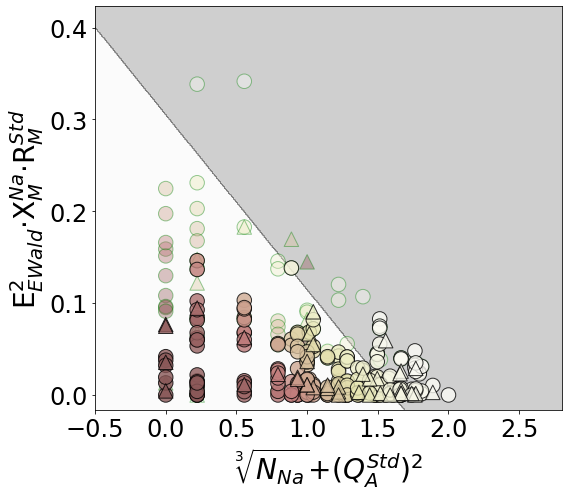

In [20]:
plt.figure(figsize=(8,7))
x_min, x_max = best_X_train[:,0].min()-0.5, best_X_train[:, 0].max()+0.5
y_min, y_max = best_X_train[:,1].min()-50, best_X_train[:, 1].max()+100

plot_stepx = (x_max-x_min)/500;
plot_stepy = (y_max-y_min)/500;
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_stepx),
                     np.arange(y_min, y_max, plot_stepy))
Z = best_clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

cs = plt.contourf(xx, yy, Z, cmap=plt.cm.binary,alpha=0.2)

plt.scatter(best_X_train[CaGe_train_inds,0],best_X_train[CaGe_train_inds,1],cmap='pink_r',marker='o',
         s=210,c=CaGe_LSGS_train_proba[:,0],edgecolors=['g' for _ in range(len(CaGe_train_inds))],alpha=0.4,
            vmin=0.0,vmax=1.0)
plt.scatter(best_X_train[CaGe_test_inds,0],best_X_train[CaGe_test_inds,1],cmap='pink_r',marker='^',
         s=210,c=CaGe_LSGS_test_proba[:,0],edgecolors=['g' for _ in range(len(CaGe_test_inds))],alpha=0.4,
            vmin=0.0,vmax=1.0)
plt.scatter(best_X_train[HfZr_train_inds,0],best_X_train[HfZr_train_inds,1],cmap='pink_r',marker='o',
         s=210,c=HfZr_LSGS_train_proba[:,0],edgecolors=['k' for _ in range(len(HfZr_train_inds))],alpha=0.8,
         vmin=0.0,vmax=1.0)
plt.scatter(best_X_test[HfZr_test_inds,0],best_X_test[HfZr_test_inds,1],cmap='pink_r',marker='^',
         s=210,c=HfZr_LSGS_test_proba[:,0],edgecolors=['k' for _ in range(len(HfZr_test_inds))],alpha=0.8,
         vmin=0.0,vmax=1.0)

_ = plt.yticks([0.00/norm_factor,0.10/norm_factor,0.20/norm_factor,0.30/norm_factor,0.40/norm_factor],
           [0.0,0.1,0.2,0.3,0.4])
_ = plt.xticks(fontsize=24); plt.yticks(fontsize=24)
plt.xlabel('$\sqrt[3]{N_{Na}}$+($Q_{A}^{Std}$)$^2$',fontsize=28)
plt.ylabel(r'E$_{EWald}^2$$\cdot$X$_{M}^{Na}$$\cdot$R$_{M}^{Std}$',fontsize=28)
plt.xlim((-0.5,2.8))
plt.ylim((-30,780))
plt.tight_layout()